# Principal component analysis for multi-spectral data

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction.
It can be used to explore patterns in high-dimensional data and assist unsupervised learning.

Principal components are a series of linear combinations of the original variables, among which the first principal component accounts for the greatest variance within a dataset.
Each subsequent principal component accounts for the next greatest possible variance and is uncorrelated with the previously defined components.

This technique is useful for understanding Sentinel-2 data as images are captured in 12 spectral bands but only 3 variables can be visualized in a RGB composite.
PCA can also be applied to timeseries data to investigate temporal evolution patterns for different land cover types.

## Description

This notebook demonstrates a principal component analysis for Sentinel-2 multi-spectal data. 
Following steps are covered:

1. Loading Sentinel-2 multi-spectral data.
2. Applying PCA to transform and visualize data.
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

from sklearn.decomposition import PCA
import datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten

### Connect to the datacube

Connect to the datacube so we can access DEAfrica data.

In [2]:
dc = datacube.Datacube(app='pca')

### Analysis parameters

This section defines the analysis parameters, including 

* center lat/lon and analysis window size for the area of interest
* time period to be investigated
* projection and resolution for loading data
* acceptable range of cloud cover percentage for input Sentinel-2 granule (`min_gooddata`)
* spectral bands to be explored

The default location is Betsiboka Estuary, Madagascar.

To limit overall memory usage, if a larger analysis window or higher resolution is desired, the time period should be reduced accordingly.

In [3]:
# Create a query object
lat, lon = -15.92, 46.35
buffer = 0.1 

query = {
    'time': ('2020-01', '2020-03'),
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'output_crs': 'epsg:6933',
    'resolution':(-20,20),
}

# use all non-overlapping 10m and 20m bands
bands = ['blue', 'green', 'red', 'red_edge_1', 'red_edge_2',
         'red_edge_3', 'nir_narrow', 'swir_1', 'swir_2']

## Loading Sentinel-2 multi-spectral data

Only high probablity cloud is excluded in this example, but this can be modified for a different area.


In [4]:
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              measurements=bands,
              min_gooddata=0.98,
              group_by='solar_day',
              **query)


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 4 out of 18 time steps with at least 98.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


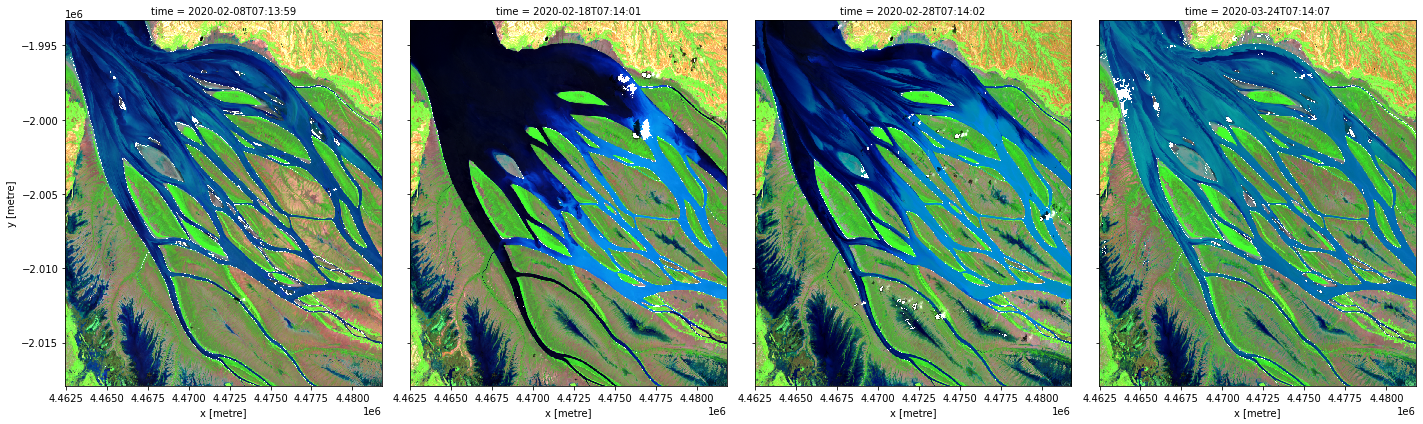

In [5]:
# visualize data using selected input spectral bands
rgb(ds, bands=['swir_1','nir_narrow','red_edge_1'], index=list(range(len(ds.time))), col_wrap=4)

## Applying PCA to transform and visualize data

To perform a PCA, data is first transformed into a numpy array that can be used by sklearn.

In [6]:
X = sklearn_flatten(ds)
print(X.shape)
print(X)

(4699223, 9)
[[ 406.  838. 1090. ...  250.  114.   98.]
 [ 378.  749.  466. ...   56.   23.   13.]
 [ 348.  880. 1854. ...  734.   28.   10.]
 ...
 [ 195.  476.  566. ... 1087.  298.  126.]
 [ 218.  484.  484. ...  884.  295.  154.]
 [ 352.  921.  563. ... 2513.  946.  454.]]


In [11]:
# !pip install sklearn-xarray

A PCA model is generated with 3 principal components and fitted on the data.

In [12]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [16]:
from sklearn_xarray import wrap

# scikit-learn expect data in the format: (n_samples, n_features) where n_features is the number of bands \
# and n_samples is the total number of pixels in each band. 
Xt = wrap(PCA(n_components=3), reshapes='feature').fit(ds)
Xt

ValueError: Found array with dim 3. Estimator expected <= 2.

We can investigate how much variance is accounted for in each principal component.
In the default example, the first principal component accounts for a much high variance than the next two.

This step can help determine whether more principal components are needed.

In [ ]:
print("Relative variance in principal components:", pca.explained_variance_ratio_)

In [ ]:
print("Relative variance in principal components:", pca1.explained_variance_ratio_)

The input data can now be transformed into this new reference space and rearranged into a xarray dataset compatible with input data.

In [ ]:
predict = pca.transform(X)
predict

In [ ]:
predict1 = pca1.transform(X1)
predict1

In [ ]:
predict1.shape

In [ ]:
9 * 4 * 1229 * 966

In [ ]:
out = sklearn_unflatten(predict, ds)
out = out.to_dataset(dim=out.dims[0]).transpose('time','y','x')
out

In [ ]:
out1 = raster_unstack(predict1, ds)
out1

### Visualise PCA results

In [ ]:
rgb(out, bands=[2,1,0], index=list(range(len(out.time))), col_wrap=4)

In [ ]:
out1.band_0.plot.imshow(cmap="Greys_r", robust=True)

In [ ]:
rgb(out1, bands=['band_2','band_1','band_2'], index=list(range(len(out.time))), col_wrap=4)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')